# Imports and settings

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Lambda, Resize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

# Import metrics library, installing it if not available
try:
    from torchmetrics.classification import Accuracy
except ImportError:
    %pip install torchmetrics -q
    from torchmetrics.classification import Accuracy

# Import model summary tool, installing it if not available
try:
    from torchinfo import summary
except ImportError:
    %pip install torchinfo -q
    from torchinfo import summary

from typing import Callable, Optional, Any
from pathlib import Path

# Set device for computation (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 12.7 MB/s eta 0:00:00


In [2]:
# Define constants for model training
TEST_SIZE=0.2
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

# Set paths for data and models
ROOT = Path("/content/drive/MyDrive/temp/")
IMAGES_PATH = ROOT/"images"
MODELS_PATH = ROOT/"models"

conf = {
    'level_1_filters': 4,
    'level_2_filters': 8,
    'dense_layer_size': 32,
    'dropout_value': 0.5
}

# Train model from scratch

## Prepare Dataset

In [ ]:
# Load the dataset
dataset = ImageFolder(
    root=str(IMAGES_PATH),
    loader=np.load,
    is_valid_file=lambda path: path.endswith(".npy") and not path.endswith("-mask.npy") and "undetermined" not in path,
    transform=Compose([
        ToImage(), # converts PIL (Python Imaging Library) to a tensor
        Resize(size=(47, 47)),
        ToDtype(torch.float32), # Convert images to float32
    ]),
    target_transform=Lambda(float), # transform the target (what we are trying to predict)
)

# Split dataset into training and testing sets
train_data, test_data = torch.utils.data.random_split(dataset, [1 - TEST_SIZE, TEST_SIZE], generator=torch.Generator().manual_seed(42))

print("Train-Test sizes:", len(train_data.indices), len(test_data.indices))

Train-Test sizes: 2137 534


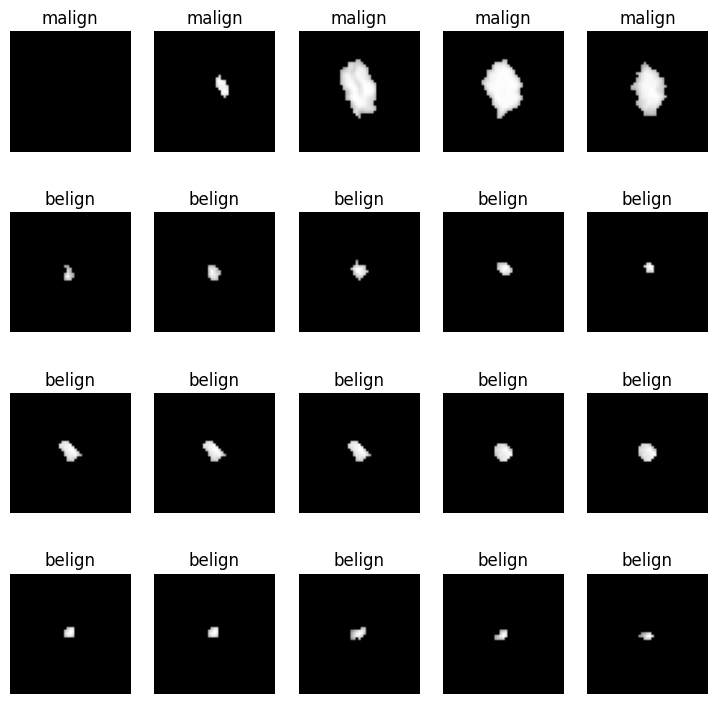

In [ ]:
# Plot some images from the training dataset
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 5
for i in range(rows):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    for j in range(cols):
        fig.add_subplot(rows, cols, i*cols + j + 1)
        plt.imshow(img.squeeze()[j, :, :], cmap="gray")
        plt.title(dataset.classes[int(label)])
        plt.axis(False)

In [ ]:
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True, # shuffle data every epoch?
    drop_last=True, # Drop the last incomplete batch
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ec174f00880>, <torch.utils.data.dataloader.DataLoader object at 0x7ec174f01990>)
Length of train dataloader: 66 batches of 32
Length of test dataloader: 17 batches of 32


## Train model

The model architecture is adapted from [this kaggle notebook](https://www.kaggle.com/code/zfturbo/keras-vs-cancer/) and was chosen for its simplicity and demonstrated effectiveness in achieving high performance in classification tasks.

In [3]:
extractor = nn.Sequential(
    # nn.ZeroPad2d((1, 1, 1, 1)),  # Padding
    nn.LazyConv2d(conf['level_1_filters'], kernel_size=3),
    nn.ReLU(),
    # nn.ZeroPad2d((1, 1, 1, 1)),
    nn.LazyConv2d(conf['level_1_filters'], kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # nn.ZeroPad2d((1, 1, 1, 1)),
    nn.LazyConv2d(conf['level_2_filters'], kernel_size=3),
    nn.ReLU(),
    # nn.ZeroPad2d((1, 1, 1, 1)),
    nn.LazyConv2d(conf['level_2_filters'], kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.LazyLinear(conf['dense_layer_size']),
    nn.Dropout(conf['dropout_value']),
    nn.ReLU(),
    nn.LazyLinear(conf['dense_layer_size']),
    nn.Dropout(conf['dropout_value']),
    nn.ReLU(),
)
classifier = nn.LazyLinear(1)

full_classifier = nn.Sequential(extractor, classifier)

summary(full_classifier, input_size=(BATCH_SIZE, 5, 47, 47))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 1]                   --
├─Sequential: 1-1                        [32, 32]                  --
│    └─Conv2d: 2-1                       [32, 4, 45, 45]           184
│    └─ReLU: 2-2                         [32, 4, 45, 45]           --
│    └─Conv2d: 2-3                       [32, 4, 43, 43]           148
│    └─ReLU: 2-4                         [32, 4, 43, 43]           --
│    └─MaxPool2d: 2-5                    [32, 4, 21, 21]           --
│    └─Conv2d: 2-6                       [32, 8, 19, 19]           296
│    └─ReLU: 2-7                         [32, 8, 19, 19]           --
│    └─Conv2d: 2-8                       [32, 8, 17, 17]           584
│    └─ReLU: 2-9                         [32, 8, 17, 17]           --
│    └─MaxPool2d: 2-10                   [32, 8, 8, 8]             --
│    └─Flatten: 2-11                     [32, 512]                 --
│    └─Line

In [ ]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
):
    """Trains 1 epoch"""

    train_loss, train_acc = 0, 0
    model.to(device)
    accuracy_fn.to(device)

    torch.compile(model)
    model.train()
    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X).squeeze()

        # Calculate loss and metrics
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach()
        # mind the order of arguments if using sklearn stuff
        train_acc += accuracy_fn(
            torch.sigmoid(y_pred).round(), # this may need to change (ex: binary vs multiclass)
            y
        )

        # Backpropagation pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader) # avg train loss PER BATCH
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
    return train_loss, train_acc

@torch.inference_mode()
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):
    """Tests 1 epoch"""

    test_loss, test_acc = 0, 0
    model.to(device)
    accuracy_fn.to(device)

    torch.compile(model)
    model.eval()
    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X).squeeze()

        # Calculate loss and metrics
        loss = loss_fn(y_pred, y)
        test_loss += loss.detach()
        # mind the order of arguments if using sklearn stuff
        test_acc += accuracy_fn(
            torch.sigmoid(y_pred).round(), # this may need to change (ex: binary vs multiclass)
            y
        )

        test_loss /= len(data_loader) # avg test loss PER BATCH
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")
    return test_loss, test_acc

We chose binary cross-entropy and accuracy as the primary metrics for evaluating our model's performance. While these metrics may not be the most suitable for our specific problem, particularly given our goal to minimize false negatives, they still provide valuable insights into the model's behavior.

In our case, the primary focus is feature extraction rather than direct classification, we must still be aware of the potential implications of misclassifications. However, the chosen metrics are sufficient for our purposes because they allow us to monitor the model's training progress and adjust hyperparameters accordingly.

It's essential to note that our ultimate goal is not to deploy the model for classification but to use it for feature extraction. In this context, binary cross-entropy and accuracy serve more as indicators of the model's learning capacity rather than definitive measures of its success. By evaluating these metrics, we can ensure that the model is learning relevant features, which can then be utilized in downstream tasks or analyses.

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=full_classifier.parameters(), lr=LEARNING_RATE)

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

accuracy_fn = Accuracy(task="binary")

best_so_far = float("-inf")
metrics = pd.DataFrame(columns=["train_loss", "test_loss", "train_acc", "test_acc"])

epochs = 10
for epoch in tqdm(range(epochs)):
    try:
        print(f"Epoch: {epoch}\n---------")
        train_loss, train_acc = train_step(
            data_loader=train_dataloader,
            model=full_classifier,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
        test_loss, test_acc = test_step(
            data_loader=test_dataloader,
            model=full_classifier,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )
        metrics.loc[len(metrics)] = { "train_loss": train_loss.item(), "test_loss": test_loss.item(), "train_acc": train_acc.item(), "test_acc": test_acc.item()}

    except KeyboardInterrupt:
        print(f"Early exiting at epoch {epoch}")
        break

    # Keep a copy of the latest model in case colab decides to die
    torch.save({
        "epoch": epoch,
        "model_state_dict": full_classifier.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        }, MODELS_PATH/f"model-latest.pt")

    # Save the best models
    if best_so_far < test_acc:
        best_so_far = test_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": full_classifier.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            }, MODELS_PATH/f"model-{test_acc:0.2f}.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.32795 | Train accuracy: 87.50%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31713 | Test accuracy: 87.22%
Epoch: 1
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.32370 | Train accuracy: 87.96%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31365 | Test accuracy: 87.22%
Epoch: 2
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.32859 | Train accuracy: 87.12%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31441 | Test accuracy: 87.50%
Epoch: 3
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.33488 | Train accuracy: 86.74%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.32136 | Test accuracy: 87.50%
Epoch: 4
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.31554 | Train accuracy: 86.89%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.32459 | Test accuracy: 87.50%
Epoch: 5
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.33483 | Train accuracy: 87.27%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.32231 | Test accuracy: 87.50%
Epoch: 6
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.31955 | Train accuracy: 87.04%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31866 | Test accuracy: 87.50%
Epoch: 7
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.33229 | Train accuracy: 86.81%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.32271 | Test accuracy: 88.07%
Epoch: 8
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.32620 | Train accuracy: 87.42%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31361 | Test accuracy: 87.50%
Epoch: 9
---------


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.31776 | Train accuracy: 87.12%


  0%|          | 0/11 [00:00<?, ?it/s]

Test loss: 0.31458 | Test accuracy: 87.78%


<Axes: title={'center': 'Losses'}>

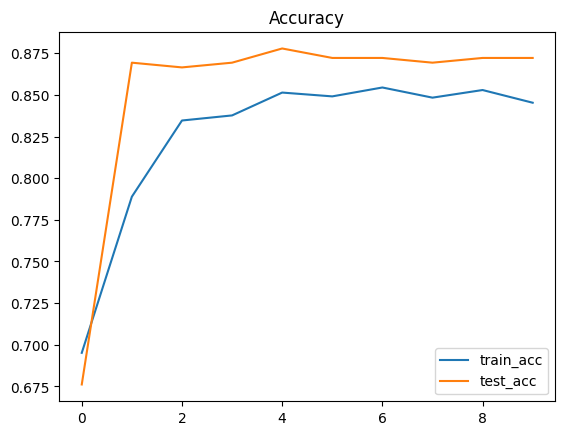

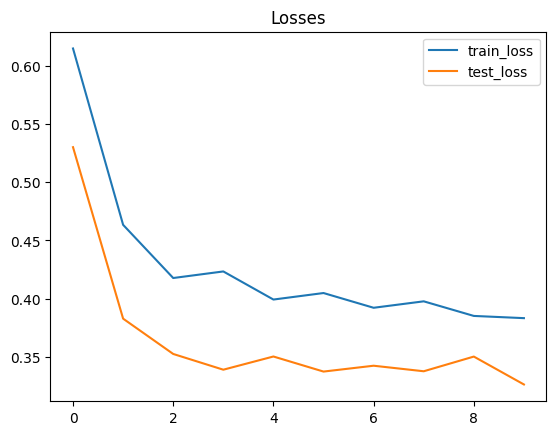

In [ ]:
# Plot metrics
metrics[["train_acc", "test_acc"]].plot(title="Accuracy")
metrics[["train_loss", "test_loss"]].plot(title="Losses")

## Inference using the best model

We selected the model with the highest accuracy for feature extraction.
This decision was made to ensure that the extracted features would be of high quality, thereby enhancing the performance of subsequent tasks.

In [4]:
chosen = "model-0.88.pt"

checkpoint = torch.load(MODELS_PATH/chosen, weights_only=True)
full_classifier.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [5]:
# Load the dataset
dataset = ImageFolder(
    root=str(IMAGES_PATH),
    loader=np.load,
    is_valid_file=lambda path: path.endswith(".npy") and not path.endswith("-mask.npy"),
    transform=Compose([
        ToImage(), # converts PIL (Python Imaging Library) to a tensor
        Resize(size=(47, 47)),
        ToDtype(torch.float32),
    ]),
    target_transform=Lambda(float), # transform the target (what we are trying to predict)
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

print(f"Length of dataloader: {len(dataloader)} batches of {BATCH_SIZE}")

Length of dataloader: 84 batches of 32


In [7]:
@torch.inference_mode()
def predict(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device = device
):
    preds = []
    model.to(device)

    torch.compile(model)
    model.eval()
    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        X, y = X.to(device), y.to(device)

        pred = model(X).squeeze()
        preds.extend(pred.cpu().numpy())

    return preds

### Shallow features

Early layers are good to capture low-level features, such as edges, textures, and basic shapes.
They tend to focus on simple patterns, which can be useful for tasks that require fine-grained details such as nodule malignancy classification.

In [7]:
shallow_extractor = nn.Sequential(*full_classifier[0][:4], nn.Flatten())
summary(shallow_extractor, input_size=(BATCH_SIZE, 5, 47, 47))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 7396]                --
├─Conv2d: 1-1                            [32, 4, 45, 45]           184
├─ReLU: 1-2                              [32, 4, 45, 45]           --
├─Conv2d: 1-3                            [32, 4, 43, 43]           148
├─ReLU: 1-4                              [32, 4, 43, 43]           --
├─Flatten: 1-5                           [32, 7396]                --
Total params: 332
Trainable params: 332
Non-trainable params: 0
Total mult-adds (M): 20.68
Input size (MB): 1.41
Forward/backward pass size (MB): 3.97
Params size (MB): 0.00
Estimated Total Size (MB): 5.38

In [8]:
extracted_features = predict(shallow_extractor, dataloader)
df = pd.DataFrame(extracted_features)
df = df.add_prefix("cnn_")

# Add ids
ids = [Path(path).name.split("-")[3].removesuffix(".npy") for path, _ in dataset.samples]
df["ID"] = ids
df

  0%|          | 0/84 [00:00<?, ?it/s]

,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,cnn_9,...,cnn_7387,cnn_7388,cnn_7389,cnn_7390,cnn_7391,cnn_7392,cnn_7393,cnn_7394,cnn_7395,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4519
2667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4522
2668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4524
2669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4526


In [9]:
df.to_csv(ROOT/"cnn_shallow.csv")

### Deep features

Deep layers are more appropriate to extract high-level features that are more task-specific and capture the overall semantics of the input data.
They encode the most abstract representations, often tuned to the classification task.

In [10]:
deep_extractor = nn.Sequential(*full_classifier[0], nn.Flatten())
summary(deep_extractor, input_size=(BATCH_SIZE, 5, 47, 47))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 32]                  --
├─Conv2d: 1-1                            [32, 4, 45, 45]           184
├─ReLU: 1-2                              [32, 4, 45, 45]           --
├─Conv2d: 1-3                            [32, 4, 43, 43]           148
├─ReLU: 1-4                              [32, 4, 43, 43]           --
├─MaxPool2d: 1-5                         [32, 4, 21, 21]           --
├─Conv2d: 1-6                            [32, 8, 19, 19]           296
├─ReLU: 1-7                              [32, 8, 19, 19]           --
├─Conv2d: 1-8                            [32, 8, 17, 17]           584
├─ReLU: 1-9                              [32, 8, 17, 17]           --
├─MaxPool2d: 1-10                        [32, 8, 8, 8]             --
├─Flatten: 1-11                          [32, 512]                 --
├─Linear: 1-12                           [32, 32]                  16,416
├─Dropo

In [11]:
extracted_features = predict(deep_extractor, dataloader)
df = pd.DataFrame(extracted_features)
df = df.add_prefix("cnn_")

# Add ids
ids = [Path(path).name.split("-")[3].removesuffix(".npy") for path, _ in dataset.samples]
df["ID"] = ids
df

  0%|          | 0/84 [00:00<?, ?it/s]

,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,cnn_9,...,cnn_23,cnn_24,cnn_25,cnn_26,cnn_27,cnn_28,cnn_29,cnn_30,cnn_31,ID
0,1.241468,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.066853,0.990587,0.272329,...,0.285106,0.231232,0.0,0.625406,0.000000,0.000000,2.069331,0.0,0.547192,102
1,0.000000,1.232410,0.000000,1.063928,1.120160,0.0,0.828725,0.000000,0.000000,1.260184,...,0.000000,0.915816,0.0,0.000000,1.252468,1.223173,0.000000,0.0,0.000000,103
2,0.000000,1.342468,0.043411,1.226732,1.113361,0.0,0.763095,0.000000,0.000000,1.068327,...,0.000000,1.023974,0.0,0.000000,1.148508,0.987634,0.000000,0.0,0.000000,109
3,0.000000,0.861694,0.000000,0.798592,0.769274,0.0,0.557115,0.000000,0.000000,0.783685,...,0.000000,0.719021,0.0,0.000000,0.775924,0.684798,0.000000,0.0,0.000000,116
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050138,0.157876,0.077221,0.101408,...,0.055109,0.156057,0.0,0.350073,0.027086,0.081437,0.373397,0.0,0.256892,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.000000,0.410857,0.000000,0.335077,0.382398,0.0,0.308489,0.000000,0.000000,0.506761,...,0.000000,0.321696,0.0,0.000000,0.511903,0.479820,0.000000,0.0,0.000000,4519
2667,0.000000,1.975172,0.000000,1.593027,1.804445,0.0,1.260259,0.000000,0.000000,1.875680,...,0.000000,1.312931,0.0,0.000000,1.857454,1.895398,0.000000,0.0,0.000000,4522
2668,0.000000,1.506138,0.102357,1.392534,1.253237,0.0,0.868990,0.000000,0.000000,1.187854,...,0.000000,1.167139,0.0,0.000000,1.263878,1.108913,0.000000,0.0,0.000000,4524
2669,0.000000,1.338855,0.000000,1.193478,1.151428,0.0,0.795956,0.000000,0.000000,1.148011,...,0.000000,0.996575,0.0,0.000000,1.185951,1.080413,0.000000,0.0,0.000000,4526


In [12]:
df.to_csv(ROOT/"cnn_deep.csv")

# Pre-trained model

In our project, we opted to utilize a pretrained model from the paper titled [3D Neural Architecture Search (NAS) for Pulmonary Nodules Classification](https://arxiv.org/abs/2101.07429). This decision was driven by several key factors, including the model's training on the same dataset, its similar preprocessing techniques, its demonstrated performance, and its relative simplicity.

The pretrained model has shown good performance metrics in the original study, particularly in terms of classification accuracy.

From the various models evaluated in the original paper, we specifically chose the one with the highest F1-score. The F1-score is a crucial metric that considers both precision and recall.

While other models might have achieved higher accuracy, the F1-score provides a more nuanced view of performance, particularly in contexts where false negatives or false positives can have significant implications.

In [3]:
# Install required dependencies
%pip install -q dill
!git clone --quiet https://github.com/fei-aiart/NAS-Lung.git
!cp -r "NAS-Lung/models" models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00


Load the choosen checkpoint.

Download model from [here](https://drive.google.com/drive/folders/1H3pBj3CA5z8xG_h3sl4R3PwBz2xj4osd)

In [4]:
orig = torch.load(ROOT/"ckpt.t7", map_location=torch.device('cpu'), weights_only=False)["net"]

net = nn.Sequential(orig.conv1, orig.conv2, nn.Flatten())
summary(net, input_size=(BATCH_SIZE, 1, 32, 32, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 20480]               --
├─Sequential: 1-1                        [32, 4, 32, 32, 5]        --
│    └─Conv3d: 2-1                       [32, 4, 32, 32, 5]        112
│    └─BatchNorm3d: 2-2                  [32, 4, 32, 32, 5]        8
│    └─ReLU: 2-3                         [32, 4, 32, 32, 5]        --
├─Sequential: 1-2                        [32, 4, 32, 32, 5]        --
│    └─Conv3d: 2-4                       [32, 4, 32, 32, 5]        436
│    └─BatchNorm3d: 2-5                  [32, 4, 32, 32, 5]        8
│    └─ReLU: 2-6                         [32, 4, 32, 32, 5]        --
├─Flatten: 1-3                           [32, 20480]               --
Total params: 564
Trainable params: 564
Non-trainable params: 0
Total mult-adds (M): 89.78
Input size (MB): 0.66
Forward/backward pass size (MB): 20.97
Params size (MB): 0.00
Estimated Total Size (MB): 21.63

In [5]:
# Load the dataset
dataset = ImageFolder(
    root=str(IMAGES_PATH),
    loader=np.load,
    is_valid_file=lambda path: path.endswith(".npy") and not path.endswith("-mask.npy"),
    transform=Compose([
        ToImage(), # converts PIL (Python Imaging Library) to a tensor
        Resize(size=(47, 47)),
        ToDtype(torch.float32),
        Lambda(lambda x: x.permute(1, 2, 0).unsqueeze(dim=0)), # ToImage messes up the dimentions
    ]),
    target_transform=Lambda(float), # transform the target (what we are trying to predict)
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

In [8]:
extracted_features = predict(net, dataloader)
df = pd.DataFrame(extracted_features)
df.columns = df.columns.astype(str)
df = df.add_prefix('cnn_')

# Add ids
ids = [Path(path).name.split("-")[3].removesuffix(".npy") for path, _ in dataset.samples]
df["ID"] = ids
df

  0%|          | 0/84 [00:00<?, ?it/s]

,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,cnn_9,...,cnn_44171,cnn_44172,cnn_44173,cnn_44174,cnn_44175,cnn_44176,cnn_44177,cnn_44178,cnn_44179,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4519
2667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4522
2668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4524
2669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4526


In [ ]:
df.to_csv(ROOT/"cnn_pretrained.csv")